In [1]:
%load_ext autoreload
%autoreload 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthpulse/pytorch_eo/blob/master/examples/eurosat.ipynb)

In this example we are going to train an image classifier with the [EuroSAT](https://github.com/phelber/EuroSAT) dataset. Let's start by exploring our dataset. EuroSAT comes in two flavours: RGB or MS. EuroSATRGB will use RGB images (uint8 with 3 channels) built from the MS variant, that contains all the spectral bands (uint16, 13 bands).

In [3]:
from pytorch_eo.datasets.eurosat import EuroSATRGB

ds = EuroSATRGB(batch_size=25, verbose=True) 

ds.setup()

data already extracted !
Number of images: 27000
training samples 16200
validation samples 5400
test samples 5400


The task consists on the classification of images in 10 classes.

In [4]:
ds.in_chans, ds.num_classes, ds.classes

(3,
 10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

Let's visualize some samples from the dataset. By default, it's already split in train-validation-test.

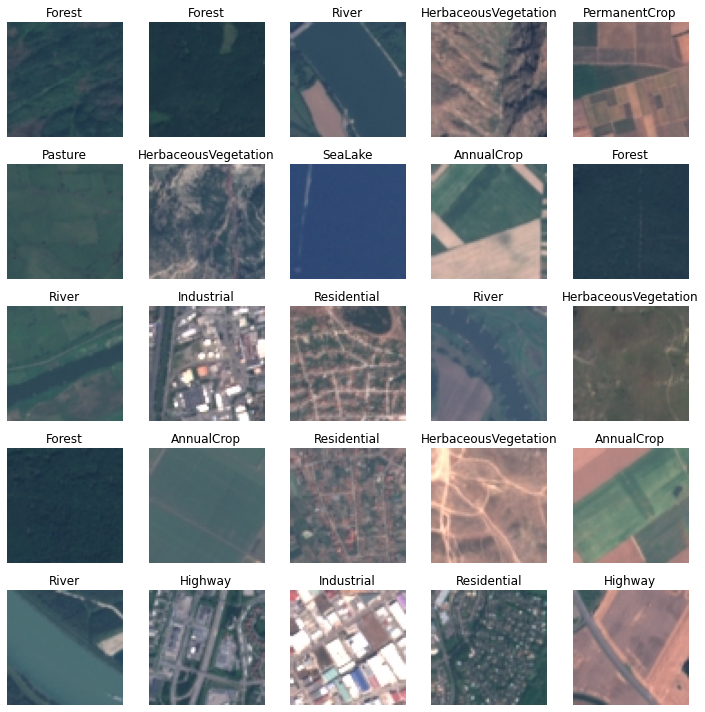

In [7]:
import matplotlib.pyplot as plt

imgs, labels = next(iter(ds.train_dataloader()))

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train an image classifier on this dataset. For that, we need a model. In this case, we are going to use a pretrained `resnet18` from the `timm` library.

In [8]:
import timm 
from pytorch_eo.tasks.classification import ImageClassification

ds = EuroSATRGB(batch_size=1024)

model = timm.create_model(
    'resnet18',
    pretrained='imagenet',
    in_chans=ds.in_chans,
    num_classes=ds.num_classes
)

task = ImageClassification(model)

We use Pytorch Lightning for training.

In [9]:
import pytorch_lightning as pl

trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=5,
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Once the model is trained, we can evaluate it on the test set.

In [10]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9855555295944214, 'test_loss': 0.05132828280329704}
--------------------------------------------------------------------------------


[{'test_acc': 0.9855555295944214, 'test_loss': 0.05132828280329704}]

And also use it to predict labels on new images.

In [11]:
import torch 
from torch.utils.data import DataLoader, SubsetRandomSampler

dl = DataLoader(
    ds.ds,
    batch_size=25,
    sampler=SubsetRandomSampler(ds.test_idxs)
)

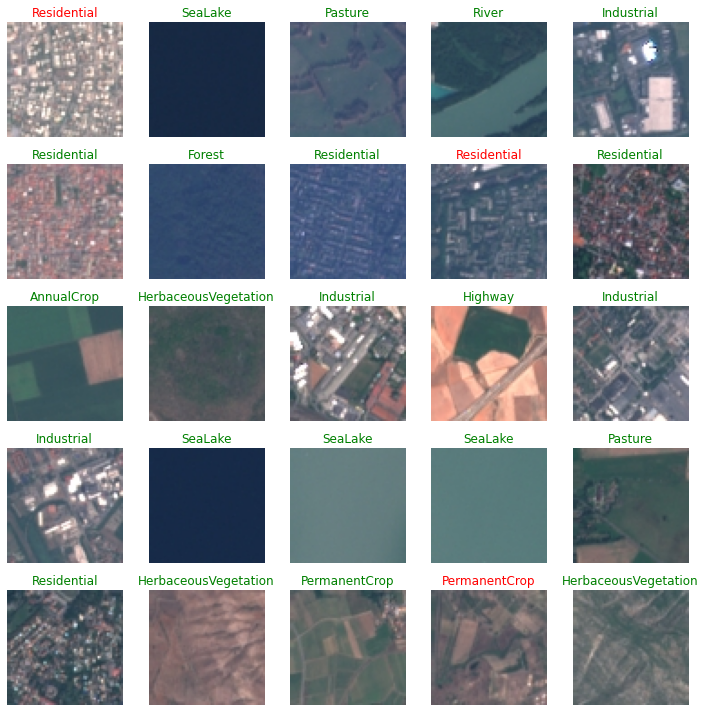

In [15]:
imgs, labels = next(iter(dl))

preds = task.predict(imgs)
preds = torch.argmax(preds, axis=1)

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs[:25], labels[:25], preds[:25])):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()